In [ ]:
!pip install datasets  # huggingface library with dataset
!pip install conllu    # aux library for processing CoNLL-U format
!pip install transformers
!pip install evaluate
!pip install accelerate

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.2/486.2 kB 12.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 26.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 17.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 46.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 32.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 12.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 27.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 9.3 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/cola

In [ ]:
import torch
import torch.nn as nn
from functools import partial
from datasets import load_dataset

## Arc-eager Parsing

In [ ]:
class ArcEager:
  def __init__(self, sentence):
    self.sentence = sentence
    self.buffer = [i for i in range(len(self.sentence))]
    self.stack = []
    self.arcs = [-1 for _ in range(len(self.sentence))]

    # shift to initialize the stack
    self.shift()

  def shift(self):
    b1 = self.buffer[0]
    self.buffer = self.buffer[1:]
    self.stack.append(b1)

  def left_arc(self):
    s = self.stack.pop()
    b = self.buffer[0]
    self.arcs[s] = b

  def right_arc(self):
    b = self.buffer[0]
    s = self.stack.pop()
    self.arcs[b] = s
    self.stack.append(s)
    self.shift()

  def reduce_arc(self):
    o1 = self.stack.pop()

  def is_tree_final(self):  # return boolean
    return (not self.buffer) and (len(self.stack) == 1)

  def print_configuration(self):
    s = [self.sentence[i] for i in self.stack]
    b = [self.sentence[i] for i in self.buffer]
    print(s, b)
    print(self.arcs)

In [ ]:
sentence = ["<ROOT>", "He", "began", "to", "write", "again", "."]
gold = [-1, 2, 0, 4, 2, 4, 2 ]

parser = ArcEager(sentence)
parser.print_configuration()

['<ROOT>'] ['He', 'began', 'to', 'write', 'again', '.']
[-1, -1, -1, -1, -1, -1, -1]


In [ ]:
parser.shift()
parser.print_configuration()

['<ROOT>', 'He'] ['began', 'to', 'write', 'again', '.']
[-1, -1, -1, -1, -1, -1, -1]


In [ ]:
parser.left_arc()
parser.print_configuration()

['<ROOT>'] ['began', 'to', 'write', 'again', '.']
[-1, 2, -1, -1, -1, -1, -1]


In [ ]:
parser.right_arc()
parser.print_configuration()

['<ROOT>', 'began'] ['to', 'write', 'again', '.']
[-1, 2, 0, -1, -1, -1, -1]


In [ ]:
parser.reduce_arc()
parser.print_configuration()

['<ROOT>'] ['to', 'write', 'again', '.']
[-1, 2, 0, -1, -1, -1, -1]


In [ ]:
parser.is_tree_final()

False

## Oracle

In [ ]:
class Oracle:
  def __init__(self, parser, gold_tree):
    self.parser = parser
    self.gold = gold_tree

  def is_left_arc_gold(self):
    if len(self.parser.buffer) == 0:
       return False # the buffer can not be empty

    s = self.parser.stack[len(self.parser.stack)-1]
    b = self.parser.buffer[0]

## if it has head or if it is the root node then false
    if self.parser.arcs[s] != -1 or s == self.parser.stack[0]:
      return False

    if self.gold[s] == b:  # if it is in the gold tree
      return True

    return False

  def is_right_arc_gold(self):

    if len(self.parser.buffer) == 0:
       return False #if buffer is empty then false

    o1 = self.parser.stack[len(self.parser.stack) - 1]
    o2 = self.parser.buffer[0]

    if self.gold[o2] != o1:
          return False # if it is in the gold tree

    return True

  def is_reduce_gold(self):

    if (self.is_left_arc_gold() or self.is_right_arc_gold()):
      return False # In order to dictate transition precedence of the parser

    #If it has head and stack is not empty
  # RE if there is a word v on the left of i(topmost stack element) in stack
# directly connected(head or dependent) with j(first element of buffer) in gold tree
    if self.parser.arcs[self.parser.stack[len(self.parser.stack)-1]] != -1 and len(self.parser.stack) > 1:
      if len(self.parser.buffer) != 0: #If buffer is not empty, a word v should be left of i(topmost stack element)
         for v in self.parser.stack:# but as i already does not have arc with j, it can not be problem here (left and right arc gold was false)
            if self.gold[v] == self.parser.buffer[0] or self.gold[self.parser.buffer[0]] == v:
               return True
      else: # Buffer is empty and we do not have left or right arc..
         return True  # in order to get the final tree we empty stack
                        # (we already have final configuration)
    return False

  def is_shift_gold(self):

    if len(self.parser.buffer) == 0:
      return False #Buffer is empty

    #This dictates transition precedence of the parser
    if (self.is_left_arc_gold() or self.is_right_arc_gold() or self.is_reduce_gold() ):
      return False

    return True


In [ ]:
sentence1 = ["<ROOT>", "He", "began", "to", "write", "again", "."]
sentence = ["<ROOT>", "He", "wrote", "her", "a" ,"letter", "."]
gold1 = [-1, 2, 0, 4, 2, 4, 2 ]
gold = [-1, 2, 0, 2, 5, 2, 2]
parser = ArcEager(sentence)
oracle = Oracle(parser, gold)

parser.print_configuration()

['<ROOT>'] ['He', 'wrote', 'her', 'a', 'letter', '.']
[-1, -1, -1, -1, -1, -1, -1]


In [ ]:
print("Left Arc: ", oracle.is_left_arc_gold())
print("Right Arc: ", oracle.is_right_arc_gold())
print("Reduce: ", oracle.is_reduce_gold())
print("Shift: ", oracle.is_shift_gold())

Left Arc:  False
Right Arc:  False
Reduce:  False
Shift:  True


In [ ]:
print('Initial configuration:')
parser.print_configuration()
while not parser.is_tree_final():
  if oracle.is_left_arc_gold():
    parser.left_arc()
    print('left arc:')
    parser.print_configuration()
  elif oracle.is_right_arc_gold():
    parser.right_arc()
    print('right arc:')
    parser.print_configuration()
  elif oracle.is_reduce_gold():
    parser.reduce_arc()
    print('reduce arc:')
    parser.print_configuration()
  elif oracle.is_shift_gold():
    parser.shift()
    print('shift arc:')
    parser.print_configuration()
# print(parser.arcs)
print("GOLD TREE:\n", oracle.gold)

Initial configuration:
['<ROOT>'] ['He', 'wrote', 'her', 'a', 'letter', '.']
[-1, -1, -1, -1, -1, -1, -1]
shift arc:
['<ROOT>', 'He'] ['wrote', 'her', 'a', 'letter', '.']
[-1, -1, -1, -1, -1, -1, -1]
left arc:
['<ROOT>'] ['wrote', 'her', 'a', 'letter', '.']
[-1, 2, -1, -1, -1, -1, -1]
right arc:
['<ROOT>', 'wrote'] ['her', 'a', 'letter', '.']
[-1, 2, 0, -1, -1, -1, -1]
right arc:
['<ROOT>', 'wrote', 'her'] ['a', 'letter', '.']
[-1, 2, 0, 2, -1, -1, -1]
shift arc:
['<ROOT>', 'wrote', 'her', 'a'] ['letter', '.']
[-1, 2, 0, 2, -1, -1, -1]
left arc:
['<ROOT>', 'wrote', 'her'] ['letter', '.']
[-1, 2, 0, 2, 5, -1, -1]
reduce arc:
['<ROOT>', 'wrote'] ['letter', '.']
[-1, 2, 0, 2, 5, -1, -1]
right arc:
['<ROOT>', 'wrote', 'letter'] ['.']
[-1, 2, 0, 2, 5, 2, -1]
reduce arc:
['<ROOT>', 'wrote'] ['.']
[-1, 2, 0, 2, 5, 2, -1]
right arc:
['<ROOT>', 'wrote', '.'] []
[-1, 2, 0, 2, 5, 2, 2]
reduce arc:
['<ROOT>', 'wrote'] []
[-1, 2, 0, 2, 5, 2, 2]
reduce arc:
['<ROOT>'] []
[-1, 2, 0, 2, 5, 2, 2]
GOLD 

## Dataset


In [ ]:
dataset = load_dataset('universal_dependencies', 'en_lines', split="train")

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/3176 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1032 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1035 [00:00<?, ? examples/s]

Dataset universal_dependencies downloaded and prepared to /root/.cache/huggingface/datasets/universal_dependencies/en_lines/2.7.0/1ac001f0e8a0021f19388e810c94599f3ac13cc45d6b5b8c69f7847b2188bdf7. Subsequent calls will reuse this data.


In [ ]:
# info about dataset
print(len(dataset))
print(dataset[1].keys())

# we look into the second sentence in the dataset and print its tokens and (gold) dependency tree
print(dataset[1]["tokens"])
print(dataset[1]["head"])

3176
dict_keys(['idx', 'text', 'tokens', 'lemmas', 'upos', 'xpos', 'feats', 'head', 'deprel', 'deps', 'misc'])
['About', 'ANSI', 'SQL', 'query', 'mode']
['5', '5', '2', '5', '0']


## Data setup (create training data and iterable dataloaders)

In [ ]:
# the function returns whether a tree is projective or not. It is currently
# implemented inefficiently by brute checking every pair of arcs.
def is_projective(tree):
  for i in range(len(tree)):
    if tree[i] == -1:
      continue
    left = min(i, tree[i])
    right = max(i, tree[i])

    for j in range(0, left):
      if tree[j] > left and tree[j] < right:
        return False
    for j in range(left+1, right):
      if tree[j] < left or tree[j] > right:
        return False
    for j in range(right+1, len(tree)):
      if tree[j] > left and tree[j] < right:
        return False

  return True

# the function creates a dictionary of word/index pairs: our embeddings vocabulary
# threshold is the minimum number of appearance for a token to be included in the embedding list
def create_dict(dataset, threshold=3):
  dic = {}  # dictionary of word counts
  for sample in dataset:
    for word in sample['tokens']:
      if word in dic:
        dic[word] += 1
      else:
        dic[word] = 1

  map = {}  # dictionary of word/index pairs. This is our embedding list
  map["<pad>"] = 0
  map["<ROOT>"] = 1
  map["<unk>"] = 2 #used for words that do not appear in our list

  next_indx = 3
  for word in dic.keys():
    if dic[word] >= threshold:
      map[word] = next_indx
      next_indx += 1

  return map

In [ ]:
train_dataset = load_dataset('universal_dependencies', 'en_lines', split="train")
dev_dataset = load_dataset('universal_dependencies', 'en_lines', split="validation")
test_dataset = load_dataset('universal_dependencies', 'en_lines', split="test")

# remove non-projective sentences: heads in the gold tree are strings, we convert them to int
train_dataset = [sample for sample in train_dataset if is_projective([-1] + [int(head) for head in sample["head"]])]
# create the embedding dictionary
emb_dictionary = create_dict(train_dataset)

print("Number of samples:")
print("Train:\t", len(train_dataset)) #(train is the number of samples without the non-projective)
print("Dev:\t", len(dev_dataset))
print("Test:\t", len(test_dataset))

Number of samples:
Train:	 2922
Dev:	 1032
Test:	 1035


In [ ]:
def process_sample(sample, get_gold_path = False):

  # put sentence and gold tree in our format
  sentence = ["<ROOT>"] + sample["tokens"]
  gold = [-1] + [int(i) for i in sample["head"]]  #heads in the gold tree are strings, we convert them to int

  # embedding ids of sentence words
  enc_sentence = [emb_dictionary[word] if word in emb_dictionary else emb_dictionary["<unk>"] for word in sentence]

  # gold_path and gold_moves are parallel arrays whose elements refer to parsing steps
  gold_path = []   # record two topmost stack tokens and first buffer token for current step
  gold_moves = []  # contains oracle (canonical) move for current step: 0 is left, 1 right, 2 shift

  if get_gold_path:  # only for training
    parser = ArcEager(sentence)
    oracle = Oracle(parser, gold)

    while not parser.is_tree_final():

      # save configuration
      configuration = [parser.stack[len(parser.stack)-2], parser.stack[len(parser.stack)-1]]
      if len(parser.buffer) == 0:
        configuration.append(-1)
      else:
        configuration.append(parser.buffer[0])
      gold_path.append(configuration)

      # save gold move
      if oracle.is_left_arc_gold():
        gold_moves.append(0)
        parser.left_arc()
      elif oracle.is_right_arc_gold():
        parser.right_arc()
        gold_moves.append(1)
      elif oracle.is_reduce_gold():
        parser.reduce_arc()
        gold_moves.append(2)
      elif oracle.is_shift_gold():
        parser.shift()
        gold_moves.append(3)

  return enc_sentence, gold_path, gold_moves, gold

In [ ]:
def prepare_batch(batch_data, get_gold_path=False):
  data = [process_sample(s, get_gold_path=get_gold_path) for s in batch_data]
  # sentences, paths, moves, trees are parallel arrays, each element refers to a sentence
  sentences = [s[0] for s in data]
  paths = [s[1] for s in data]
  moves = [s[2] for s in data]
  trees = [s[3] for s in data]
  return sentences, paths, moves, trees

In [ ]:
BATCH_SIZE = 32

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=partial(prepare_batch, get_gold_path=True))
dev_dataloader = torch.utils.data.DataLoader(dev_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=partial(prepare_batch))
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=partial(prepare_batch))

## Data Analysis

The Universal Dependencies (UD) Treebank is a project that provides consistent and unified syntactic annotations for multiple languages. It represents sentence structure using labeled dependency relations between words. The annotations follow a dependency-based approach, capturing grammatical relationships. The UD Treebank ensures cross-linguistic consistency, covering various languages in a standardized format known as CoNLL-U. It includes predefined training, development, and test splits and may contain additional linguistic annotations. The project is valuable for NLP researchers and developers, facilitating cross-linguistic comparison and supporting diverse language processing tasks. Moreover, it still continues to expand.

Here below we do small data analysis with sentence showing length distribution, POS tag frequency and most common words over training, development and test splits of UD Treebank.

In [ ]:
from collections import Counter
import matplotlib.pyplot as plt

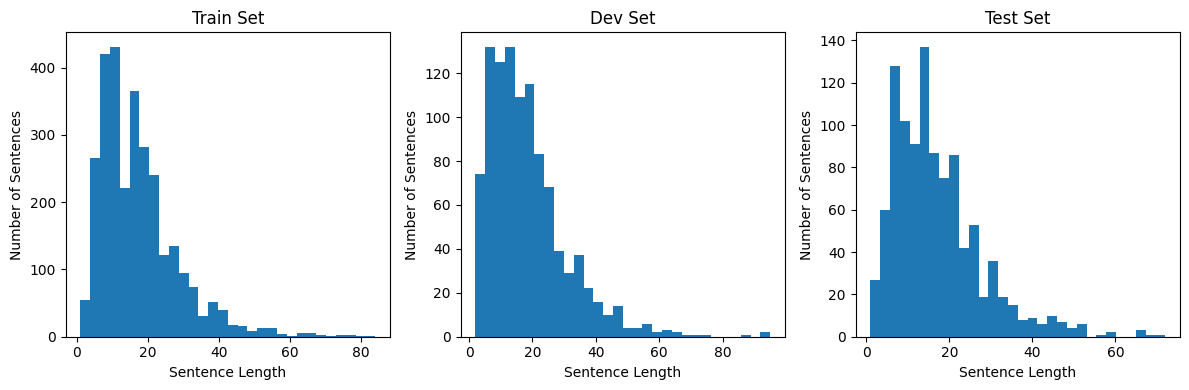

In [ ]:
train_lengths = [len(sentence['tokens']) for sentence in train_dataset]
dev_lengths = [len(sentence['tokens']) for sentence in dev_dataset]
test_lengths = [len(sentence['tokens']) for sentence in test_dataset]
fig, axs = plt.subplots(1, 3, figsize=(12, 4))
# Plot the histogram of sentence lengths
axs[0].hist(train_lengths, bins=30)
axs[0].set_title('Train Set')
axs[0].set_xlabel('Sentence Length')
axs[0].set_ylabel('Number of Sentences')

axs[1].hist(dev_lengths, bins=30)
axs[1].set_title('Dev Set')
axs[1].set_xlabel('Sentence Length')
axs[1].set_ylabel('Number of Sentences')

axs[2].hist(test_lengths, bins=30)
axs[2].set_title('Test Set')
axs[2].set_xlabel('Sentence Length')
axs[2].set_ylabel('Number of Sentences')

plt.tight_layout()
plt.show()


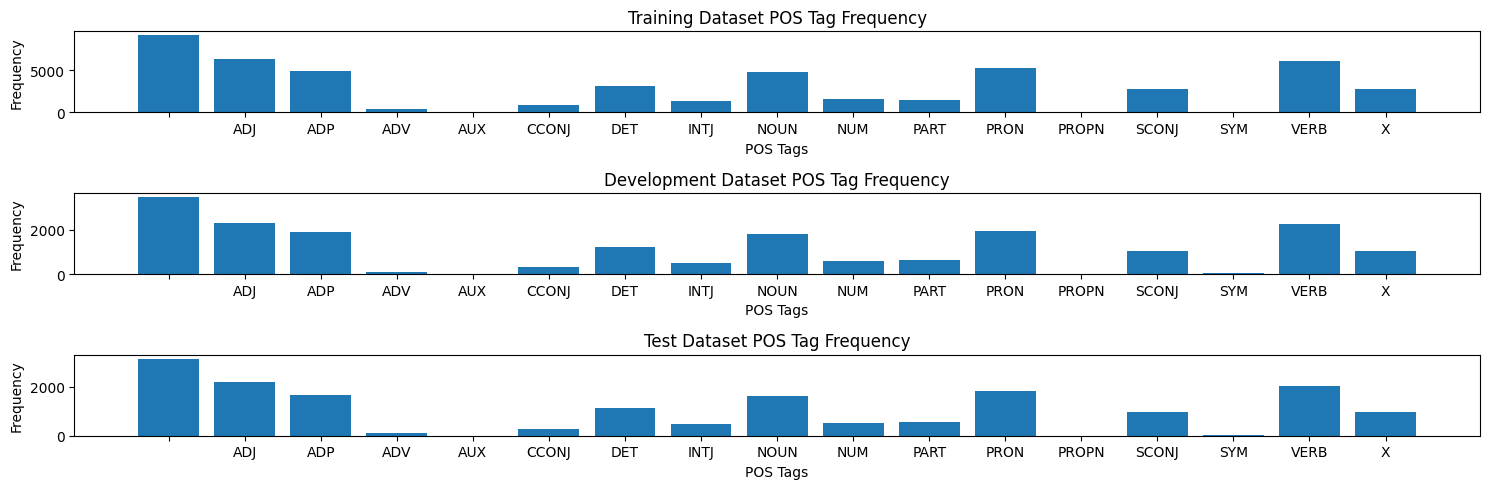

In [ ]:
# Define the mapping of upos numbers to their corresponding string tags
upos_mapping = {
    1: 'ADJ',
    2: 'ADP',
    3: 'ADV',
    4: 'AUX',
    5: 'CCONJ',
    6: 'DET',
    7: 'INTJ',
    8: 'NOUN',
    9: 'NUM',
    10: 'PART',
    11: 'PRON',
    12: 'PROPN',
    13: 'PUNCT',
    14: 'SCONJ',
    15: 'SYM',
    16: 'VERB',
    17: 'X'
}

# Convert upos values to string tags for each dataset
train_pos_tags = [upos_mapping.get(token, '') for sentence in train_dataset for token in sentence.get('upos', [])]
dev_pos_tags = [upos_mapping.get(token, '') for sentence in dev_dataset for token in sentence.get('upos', [])]
test_pos_tags = [upos_mapping.get(token, '') for sentence in test_dataset for token in sentence.get('upos', [])]

# Get the unique POS tags from all datasets and sort them
all_pos_tags = sorted(set(train_pos_tags + dev_pos_tags + test_pos_tags))

# Calculate POS tag frequency distributions
train_pos_freq = Counter(train_pos_tags)
dev_pos_freq = Counter(dev_pos_tags)
test_pos_freq = Counter(test_pos_tags)

# Plot the POS tag frequency distributions
plt.figure(figsize=(15, 5))

plt.subplot(3, 1, 1)
plt.bar(all_pos_tags, [train_pos_freq[tag] for tag in all_pos_tags])
plt.title('Training Dataset POS Tag Frequency')
plt.xlabel('POS Tags')
plt.ylabel('Frequency')

plt.subplot(3, 1, 2)
plt.bar(all_pos_tags, [dev_pos_freq[tag] for tag in all_pos_tags])
plt.title('Development Dataset POS Tag Frequency')
plt.xlabel('POS Tags')
plt.ylabel('Frequency')

plt.subplot(3, 1, 3)
plt.bar(all_pos_tags, [test_pos_freq[tag] for tag in all_pos_tags])
plt.title('Test Dataset POS Tag Frequency')
plt.xlabel('POS Tags')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [ ]:
def get_tokens_from_dataset(dataset):
    tokens = []
    for example in dataset:
        tokens.extend(example['tokens'])
    return tokens

train_tokens = get_tokens_from_dataset(train_dataset)
dev_tokens = get_tokens_from_dataset(dev_dataset)
test_tokens = get_tokens_from_dataset(test_dataset)

train_token_counts = Counter(train_tokens)
dev_token_counts = Counter(dev_tokens)
test_token_counts = Counter(test_tokens)

most_common_train = train_token_counts.most_common(10)
most_common_dev = dev_token_counts.most_common(10)
most_common_test = test_token_counts.most_common(10)

print(f"Most common tokens in the training dataset:")
print(most_common_train)
print(f"\nMost common tokens in the development dataset:")
print(most_common_dev)
print(f"\nMost common tokens in the test dataset:")
print(most_common_test)

Most common tokens in the training dataset:
[(',', 2668), ('.', 2571), ('the', 2554), ('to', 1213), ('of', 1173), ('a', 1168), ('and', 1131), ('in', 703), ('was', 644), ('I', 526)]

Most common tokens in the development dataset:
[(',', 977), ('the', 968), ('.', 964), ('of', 466), ('and', 462), ('a', 444), ('to', 413), ('in', 290), ('was', 209), ('I', 199)]

Most common tokens in the test dataset:
[(',', 942), ('.', 935), ('the', 885), ('to', 416), ('and', 401), ('of', 398), ('a', 378), ('in', 254), ('I', 209), ('was', 185)]


## Bi-lstm model (baseline)

The baseline model provided is a neural network-based dependency parser. Here's a description of the model and its components:

Embeddings: The model starts with an embedding layer (self.embeddings) that maps input tokens to continuous vector representations. The embeddings are initialized with word embeddings (emb_dictionary) and are of size EMBEDDING_SIZE.
Bi-LSTM: The model utilizes a bidirectional LSTM (self.lstm) to capture contextual information from the input embeddings. The LSTM takes the embeddings as input and produces hidden states (h) as output. The LSTM has LSTM_SIZE hidden units and LSTM_LAYERS layers. Dropout regularization is applied to the LSTM output.
Feedforward: The model employs a feedforward neural network for making predictions based on the LSTM output. The feedforward network consists of two linear layers: self.w1 and self.w2. self.w1 maps the concatenated LSTM outputs (6 times LSTM_SIZE because configuration is consist of 3 elements, words and we learn for each of them and as it is bi-lstm) to an intermediate size (MLP_SIZE) using a bias term. The intermediate layer is passed through the hyperbolic tangent activation function. The output of self.activation is then transformed by self.w2 to produce a final prediction of size 4, corresponding to different possible actions. A softmax function (self.softmax) is applied to the output to obtain a probability distribution over the actions.
Dropout: Dropout regularization is applied to the LSTM output and the intermediate layer of the feedforward network using self.dropout. This helps prevent overfitting during training by randomly zeroing out some elements.

The model's forward method takes input sequences and paths as input and performs the following steps:

- Passes the sequences through the LSTM to obtain hidden states (h).
- Generates input for the feedforward network (mlp_input) based on the given paths (configurations are the indicators of the steps for the oracle of Arc-Eager) and the LSTM output.
- Runs the feedforward network and obtains the scores for each possible action.
- Returns the output scores.

In order to test the model, we use again LSTM representation of input sequences and choose corresponding words in configurations in order calculate the predictions and initializes parsers for each sequence, performs parsing steps based on the highest-scoring actions predicted by the model(if it is not possible to do then the second highest-scoring is chosen if the action is not obvious), and returns the predicted dependency trees.

The get_configurations method retrieves the current configurations from the parsers, and the parsed_all method checks if all parsers have reached a final parsing state.

Overall, the model aims to predict the dependency relations between words in a sentence by combining embeddings ids of words, bidirectional LSTM, and a feedforward network. It uses the ArcEager transition system for parsing, where actions such as shift, reduce, left-arc, and right-arc are performed to build a dependency tree for each input sentence


In [ ]:
EMBEDDING_SIZE = 200
LSTM_SIZE = 200
LSTM_LAYERS = 1
MLP_SIZE = 200
DROPOUT = 0.2
EPOCHS = 15
LR = 0.001   # learning rate

In [ ]:
class Net(nn.Module):

  def __init__(self, device):
    super(Net, self).__init__()
    self.device = device
    self.embeddings = nn.Embedding(len(emb_dictionary), EMBEDDING_SIZE, padding_idx=emb_dictionary["<pad>"])

    # initialize bi-LSTM
    self.lstm = nn.LSTM(EMBEDDING_SIZE, LSTM_SIZE, num_layers = LSTM_LAYERS, bidirectional=True, dropout=DROPOUT)

    # initialize feedforward
    self.w1 = torch.nn.Linear(6*LSTM_SIZE, MLP_SIZE, bias=True)
    self.activation = torch.nn.Tanh()
    self.w2 = torch.nn.Linear(MLP_SIZE, 4, bias=True)
    self.softmax = torch.nn.Softmax(dim=-1)

    self.dropout = torch.nn.Dropout(DROPOUT)


  def forward(self, x, paths):
    # get the embeddings
    x = [self.dropout(self.embeddings(torch.tensor(i).to(self.device))) for i in x]

    # run the bi-lstm
    h = self.lstm_pass(x)

    # for each parser configuration that we need to score we arrange from the
    # output of the bi-lstm the correct input for the feedforward
    mlp_input = self.get_mlp_input(paths, h)

    # run the feedforward and get the scores for each possible action
    out = self.mlp(mlp_input)

    return out

  def lstm_pass(self, x):
    x = torch.nn.utils.rnn.pack_sequence(x, enforce_sorted=False)
    h, (h_0, c_0) = self.lstm(x)
    h, h_sizes = torch.nn.utils.rnn.pad_packed_sequence(h) # size h: (length_sentences, batch, output_hidden_units)
    return h

  def get_mlp_input(self, configurations, h):
    mlp_input = []
    zero_tensor = torch.zeros(2*LSTM_SIZE, requires_grad=False).to(self.device)
    for i in range(len(configurations)): # for every sentence in the batch
      for j in configurations[i]: # for each configuration of a sentence
        mlp_input.append(torch.cat([zero_tensor if j[0]==-1 else h[j[0]][i], zero_tensor if j[1]==-1 else h[j[1]][i], zero_tensor if j[2]==-1 else h[j[2]][i]]))
    mlp_input = torch.stack(mlp_input).to(self.device)
    return mlp_input

  def mlp(self, x):
    return self.softmax(self.w2(self.dropout(self.activation(self.w1(self.dropout(x))))))

  # we use this function at inference time. We run the parser and at each step
  # we pick as next move the one with the highest score assigned by the model
  def infere(self, x):

    parsers = [ArcEager(i) for i in x]

    x = [self.embeddings(torch.tensor(i).to(self.device)) for i in x]

    h = self.lstm_pass(x)

    while not self.parsed_all(parsers):
      # get the current configuration and score next moves
      configurations = self.get_configurations(parsers)
      mlp_input = self.get_mlp_input(configurations, h)
      mlp_out = self.mlp(mlp_input)
      # take the next parsing step
      moves_argm = mlp_out.argmax(-1)
      self.parse_step(parsers, mlp_out)
    # return the predicted dependency tree
    return [parser.arcs for parser in parsers]

  def get_configurations(self, parsers):
    configurations = []

    for parser in parsers:
      if parser.is_tree_final():
        conf = [-1, -1, -1]
      else:
        conf = [parser.stack[len(parser.stack)-2], parser.stack[len(parser.stack)-1]]
        if len(parser.buffer) == 0:
          conf.append(-1)
        else:
          conf.append(parser.buffer[0])
      configurations.append([conf])

    return configurations

  def parsed_all(self, parsers):
    for parser in parsers:
      if not parser.is_tree_final():
        return False
    return True

  # In this function we select and perform the next move according to the scores obtained.
  # We need to be careful and select correct moves, e.g. don't do a shift if the buffer
  # is empty or a left arc if σ2 is the ROOT. For clarity sake we didn't implement
  # these checks in the parser so we must do them here. This renders the function quite ugly
  def parse_step(self, parsers, moves):
    moves_argm = moves.argmax(-1)
    for i in range(len(parsers)):
      if parsers[i].is_tree_final():
        continue
      else: #consider also the case which toplast element has a head

        if len(parsers[i].buffer) == 0:
          parsers[i].reduce_arc()

        elif moves_argm[i] == 0:
          if parsers[i].stack[len(parsers[i].stack)-1] != 0:
              parsers[i].left_arc() #if it is not root in the stack and buffer is not empty
          else: #there is only root in stack and buffer is not empty otherwise tree would be final
            if moves[i][1] > moves[i][3]:
              parsers[i].right_arc()  # if score of right_arc is more than shift then right_arc
            else:
              parsers[i].shift()

        elif moves_argm[i] == 1:
            parsers[i].right_arc()

        elif moves_argm[i] == 2:
          if (len(parsers[i].stack) > 1 and parsers[i].arcs[parsers[i].stack[len(parsers[i].stack)-1]] != -1) or len(parsers[i].buffer) == 0:
            parsers[i].reduce_arc()
          else:
            if parsers[i].stack[len(parsers[i].stack)-1] != 0:
              parsers[i].left_arc()
            else:
              if moves[i][1] > moves[i][3]: #being right_arc is more probable than shift do right_arc
                parsers[i].right_arc()
              else:
                parsers[i].shift()

        elif moves_argm[i] ==3:
            parsers[i].shift()


In [ ]:
def evaluate(gold, preds):
  total = 0
  correct = 0

  for g, p in zip(gold, preds):
    for i in range(1,len(g)):
      total += 1
      if g[i] == p[i]:
        correct += 1

  return correct/total

In [ ]:
def train(model, dataloader, criterion, optimizer):
  model.train()
  total_loss = 0
  count = 0

  for batch in dataloader:
    optimizer.zero_grad()
    sentences, paths, moves, trees = batch

    out = model(sentences, paths)
    labels = torch.tensor(sum(moves, [])).to(device) #sum(moves, []) flatten the array
    loss = criterion(out, labels)

    count +=1
    total_loss += loss.item()

    loss.backward()
    optimizer.step()

  return total_loss/count

def test(model, dataloader):
  model.eval()

  gold = []
  preds = []

  for batch in dataloader:
    sentences, paths, moves, trees = batch
    with torch.no_grad():
      pred = model.infere(sentences)

      gold += trees
      preds += pred

  return evaluate(gold, preds)

## Evaluation: use unlabeled attachment score (UAS)

In [ ]:
# device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
# device = torch.device("cpu")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)
model = Net(device)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)


for epoch in range(EPOCHS):
  # print("check 1")
  avg_train_loss = train(model, train_dataloader, criterion, optimizer)
  # print("train check")
  val_uas = test(model, dev_dataloader)

  print("Epoch: {:3d} | avg_train_loss: {:5.3f} | dev_uas: {:5.3f} |".format( epoch, avg_train_loss, val_uas))

Device: cpu


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch:   0 | avg_train_loss: 1.055 | dev_uas: 0.548 |
Epoch:   1 | avg_train_loss: 0.924 | dev_uas: 0.622 |
Epoch:   2 | avg_train_loss: 0.886 | dev_uas: 0.642 |
Epoch:   3 | avg_train_loss: 0.868 | dev_uas: 0.678 |
Epoch:   4 | avg_train_loss: 0.857 | dev_uas: 0.691 |
Epoch:   5 | avg_train_loss: 0.847 | dev_uas: 0.698 |
Epoch:   6 | avg_train_loss: 0.838 | dev_uas: 0.705 |
Epoch:   7 | avg_train_loss: 0.832 | dev_uas: 0.712 |
Epoch:   8 | avg_train_loss: 0.827 | dev_uas: 0.717 |
Epoch:   9 | avg_train_loss: 0.822 | dev_uas: 0.717 |
Epoch:  10 | avg_train_loss: 0.817 | dev_uas: 0.715 |
Epoch:  11 | avg_train_loss: 0.813 | dev_uas: 0.727 |
Epoch:  12 | avg_train_loss: 0.810 | dev_uas: 0.735 |
Epoch:  13 | avg_train_loss: 0.807 | dev_uas: 0.726 |
Epoch:  14 | avg_train_loss: 0.804 | dev_uas: 0.736 |


In [ ]:
test_uas = test(model, test_dataloader)
print("test_uas: {:5.3f}".format( test_uas))

test_uas: 0.743


In [ ]:
https://colab.research.google.com/drive/1SH9X-Vg6zwurkDLNqog9di3Gwg5G3qKy#scrollTo=JBClbDEg59RB&line=15&uniqifier=1